In [1]:
import os

import matplotlib.pyplot as plt
import numpy as np

"Machine learning tools"
import pickle

from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.model_selection import StratifiedKFold, train_test_split


from classification.datasets import Dataset
from classification.utils.audio_student import AudioUtil, Feature_vector_DS

from classification.utils.plots import (
    plot_decision_boundaries,
    plot_specgram,
    show_confusion_matrix,
)
from classification.utils.utils import accuracy
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

2025-05-04 23:43:45.661835: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-04 23:43:45.692514: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-04 23:43:45.872630: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-04 23:43:46.035223: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1746395026.167005   17698 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1746395026.20

In [2]:
np.random.seed(0)

In [3]:
### TO RUN
dataset = Dataset()
classnames = dataset.list_classes()

print("\n".join(classnames))

chainsaw
fire
fireworks
gunshot


In [4]:
### TO RUN
fm_dir = "data/feature_matrices/"  # where to save the features matrices
model_dir = "data/models/cnn"  # where to save the models
os.makedirs(fm_dir, exist_ok=True)
os.makedirs(model_dir, exist_ok=True)

In [5]:
### TO RUN

"Creation of the dataset"
myds = Feature_vector_DS(dataset, Nft=512, nmel=20, duration=950, shift_pct=0.0)

"Some attributes..."
myds.nmel
myds.duration
myds.shift_pct
myds.sr
myds.data_aug
myds.ncol

idx = 0


We can now create a new augmented dataset and observe if the classification results improve. 

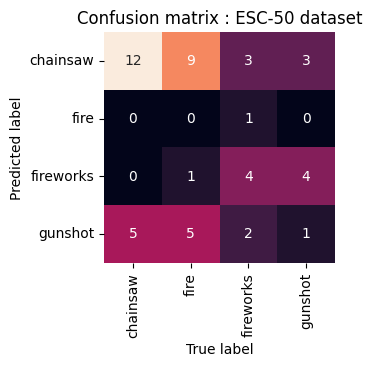

In [6]:
import numpy as np
from classification.utils.plots import show_confusion_matrix

# Matrice de confusion fournie
cm = np.array([
    [12,  0,  0, 5],
    [9,  0,  1,  5],
    [3,  1,  4,  2],
    [3,  0,  4,  1]
])

classnames = ["chainsaw", "fire", "fireworks", "gunshot"]

# Reconstruction de y_true et y_pred
y_true = []
y_pred = []

for true_label, row in enumerate(cm):
    for pred_label, count in enumerate(row):
        y_true.extend([true_label] * count)
        y_pred.extend([pred_label] * count)

# Affichage de la matrice de confusion
show_confusion_matrix(y_pred, y_true, classnames, title="Confusion matrix : ESC-50 dataset")


In [7]:

import numpy as np
from sklearn.calibration import LabelEncoder
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler

data_aug_factor = 1
featveclen = len(myds["fire", 0, "", ""])  # Same for all classes
classnames = ["chainsaw", "fire", "fireworks", "gunshot"]  # Or wherever you store class names
nclass = len(classnames)

# Determine number of samples per class
naudio_per_class = {cls: len(dataset.files.get(cls, [])) for cls in classnames}
print(naudio_per_class)

# Allocate feature matrix
total_samples_basic = sum(naudio_per_class[c] for c in classnames)

X_train = []
X_test = []
y_train = []
y_test = []

for class_idx, classname in enumerate(classnames):
    for i in range(naudio_per_class[classname]):
        featvec = myds[classname, i, "", ""]
        if i < naudio_per_class[classname] * 0.8:
            X_train.append(featvec)
            y_train.append(classname)
        else:
            X_test.append(featvec)
            y_test.append(classname)

# Split the dataset into training and testing sets
X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

# Normalization of the data
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)
X_test_norm = scaler.transform(X_test)
with open(os.path.join(model_dir, f"scaler.pkl"), "wb") as f:
    pickle.dump(scaler, f)

label_encoder           = LabelEncoder()
y_train     = label_encoder.fit_transform(y_train)
y_test      = label_encoder.transform(y_test)
with open(os.path.join(model_dir, f"label_encoder.pkl"), "wb") as f:
    pickle.dump(label_encoder, f)

# Save the feature matrix and labels
np.save(os.path.join(fm_dir, "X_train.npy"), X_train)
np.save(os.path.join(fm_dir, "X_test.npy"), X_test)
np.save(os.path.join(fm_dir, "y_train.npy"), y_train)
np.save(os.path.join(fm_dir, "y_test.npy"), y_test)
np.save(os.path.join(fm_dir, "X_train_norm.npy"), X_train_norm)
np.save(os.path.join(fm_dir, "X_test_norm.npy"), X_test_norm)

print(f"Shape of the training matrix : {X_train.shape}")
print(f"Shape of the test matrix : {X_test.shape}")

{'chainsaw': 315, 'fire': 303, 'fireworks': 315, 'gunshot': 40}
Shape of the training matrix : (779, 400)
Shape of the test matrix : (194, 400)


In [8]:
from classification.utils.plots import plot_specgram_textlabel
import os
import numpy as np
import matplotlib.pyplot as plt

BASIC = False
if BASIC:
    # Charger les données
    X = np.load(os.path.join(fm_dir, "X_train_aug.npy"), allow_pickle=True)
    y = np.load(os.path.join(fm_dir, "y_train_aug.npy"), allow_pickle=True)

    # Dossier où sauvegarder les images
    save_dir = os.path.join("src/classification/melspec_aug")
    os.makedirs(save_dir, exist_ok=True)

    # Initialiser les compteurs par classe
    class_counters = {}

    for i in range(len(X)):
        melspec = X[i]
        class_of_spec = y[i]

        # Ne traiter que si on a < 10 exemples pour cette classe
        if class_of_spec not in class_counters:
            class_counters[class_of_spec] = 0
        if class_counters[class_of_spec] >= 10:
            continue

        class_idx = class_counters[class_of_spec]

        # Affichage + sauvegarde
        fig, ax = plt.subplots()
        plot_specgram_textlabel(
            melspec.reshape((20, 20)),
            ax=ax,
            is_mel=True,
            title=f"MEL Spectrogram - {class_of_spec} #{class_idx}",
            xlabel="Mel vector",
            textlabel=f"{class_of_spec}",
        )
        plt.tight_layout()
        save_path = os.path.join(save_dir, f"melspec_{class_of_spec}_{class_idx}.png")
        fig.savefig(save_path)
        plt.close(fig)

        class_counters[class_of_spec] += 1


In [ ]:
### AUGMENTED DATASET
TEST_WITH_AUGMENTED_FV = False

list_augmentation = ["original", "noise", "shifting"]
myds.mod_data_aug(list_augmentation)
print("Number of transformations : ", myds.data_aug_factor)

n_bands = 20
frames = 20
# Préparer les splits
X_train_list, y_train_list = [], []
X_test_list,  y_test_list  = [], []

for classname in classnames:
    n = naudio_per_class[classname]

    # Création des indices de base pour les sons originaux
    limit = round(n*0.8)
    train_idx = list(range(limit))
    test_idx  = list(range(limit+1, n))
    
    for i in train_idx:
        for aug in list_augmentation:
            featvec = myds[classname, i, aug, ""]
            X_train_list.append(featvec)
            y_train_list.append(classname)

    for i in test_idx:
        if TEST_WITH_AUGMENTED_FV:
            for aug in list_augmentation:
                featvec = myds[classname, i, aug, ""]
                X_test_list.append(featvec)
                y_test_list.append(classname)
        else:
            featvec = myds[classname, i, "", ""]
            X_test_list.append(featvec)
            y_test_list.append(classname)

# Conversion en tableaux numpy
X_train_aug = np.array(X_train_list)
y_train_aug = np.array(y_train_list, dtype=object)

X_test_aug = np.array(X_test_list)
y_test_aug = np.array(y_test_list, dtype=object)

# --- 1) Z-SCORE GLOBAL -------------------------------
scaler_global = StandardScaler().fit(X_train_aug)
X_train_aug_norm_zscore_global = scaler_global.transform(X_train_aug)
X_test_aug_norm_zscore_global  = scaler_global.transform(X_test_aug)

with open(os.path.join(model_dir, "scaler_aug_zscore_global.pkl"), "wb") as f:
    pickle.dump(scaler_global, f)
np.save(os.path.join(fm_dir, "X_train_aug_norm_zscore_global.npy"), X_train_aug_norm_zscore_global)
np.save(os.path.join(fm_dir, "X_test_aug_norm_zscore_global.npy"),  X_test_aug_norm_zscore_global)

# --- 2) Z-SCORE PAR BANDE MEL ------------------------------------
X_train_resh = X_train_aug.reshape(-1, n_bands, frames)
X_test_resh  = X_test_aug.reshape(-1, n_bands, frames)

mean_band = X_train_resh.mean(axis=(0, 2))          # (20,)
std_band  = X_train_resh.std(axis=(0, 2)) + 1e-8    # (20,)

X_train_aug_norm_zscore_band = ((X_train_resh - mean_band[None,:,None])
                           / std_band[None,:,None]).reshape(-1, n_bands*frames)
X_test_aug_norm_zscore_band  = ((X_test_resh  - mean_band[None,:,None])
                           / std_band[None,:,None]).reshape(-1, n_bands*frames)

np.save(os.path.join(model_dir, "zscore_band_mean.npy"), mean_band)
np.save(os.path.join(model_dir, "zscore_band_std.npy"),  std_band)
np.save(os.path.join(fm_dir, "X_train_aug_norm_zscore_band.npy"), X_train_aug_norm_zscore_band)
np.save(os.path.join(fm_dir, "X_test_aug_norm_zscore_band.npy"),  X_test_aug_norm_zscore_band)

# --- 3) MIN-MAX PAR BANDE MEL ------------------------------------
min_band = X_train_resh.min(axis=(0, 2))
max_band = X_train_resh.max(axis=(0, 2)) + 1e-8

X_train_aug_norm_minmax = ((X_train_resh - min_band[None,:,None])
                           / (max_band - min_band)[None,:,None]).reshape(-1, n_bands*frames)
X_test_aug_norm_minmax  = ((X_test_resh  - min_band[None,:,None])
                           / (max_band - min_band)[None,:,None]).reshape(-1, n_bands*frames)

np.save(os.path.join(model_dir, "min_band.npy"), min_band)
np.save(os.path.join(model_dir, "max_band.npy"), max_band)
np.save(os.path.join(fm_dir, "X_train_aug_norm_minmax.npy"), X_train_aug_norm_minmax)
np.save(os.path.join(fm_dir, "X_test_aug_norm_minmax.npy"),  X_test_aug_norm_minmax)

# --- 4) GLOBAL MAX NORMALIZATION -------------------------------
# Chaque spectrogramme est divisé par son max propre (par ligne)
X_train_aug_norm_max = X_train_aug.copy().astype(np.float32)
X_test_aug_norm_max  = X_test_aug.copy().astype(np.float32)

X_train_max = X_train_aug_norm_max.max(axis=1, keepdims=True) + 1e-8 # éviter la division par 0
X_test_max  = X_test_aug_norm_max.max(axis=1, keepdims=True) + 1e-8

X_train_aug_norm_max /= X_train_max
X_test_aug_norm_max  /= X_test_max

np.save(os.path.join(fm_dir, "X_train_aug_norm_max.npy"), X_train_aug_norm_max)
np.save(os.path.join(fm_dir, "X_test_aug_norm_max.npy"),  X_test_aug_norm_max)

# --- 5) L2 NORMALIZATION -------------------------------
X_train_aug_norm_l2 = X_train_aug.copy().astype(np.float32)
X_test_aug_norm_l2  = X_test_aug.copy().astype(np.float32)

X_train_l2 = np.sqrt(np.sum(X_train_aug_norm_l2**2, axis=1, keepdims=True)) + 1e-8
X_test_l2  = np.sqrt(np.sum(X_test_aug_norm_l2**2, axis=1, keepdims=True)) + 1e-8

X_train_aug_norm_l2 /= X_train_l2
X_test_aug_norm_l2  /= X_test_l2

np.save(os.path.join(fm_dir, "X_train_aug_norm_l2.npy"), X_train_aug_norm_l2)
np.save(os.path.join(fm_dir, "X_test_aug_norm_l2.npy"),  X_test_aug_norm_l2)


# Label encoding
label_encoder_aug = LabelEncoder()
y_train_aug     = label_encoder_aug.fit_transform(y_train_aug)
y_test_aug      = label_encoder_aug.transform(y_test_aug)
with open(os.path.join(model_dir, f"label_encoder_aug.pkl"), "wb") as f:
    pickle.dump(label_encoder_aug, f)

np.save(os.path.join(fm_dir, "X_train_aug.npy"), X_train_aug)
np.save(os.path.join(fm_dir, "X_test_aug.npy"), X_test_aug)
np.save(os.path.join(fm_dir, "y_train_aug.npy"), y_train_aug)
np.save(os.path.join(fm_dir, "y_test_aug.npy"), y_test_aug)

print(f"Shape of the training matrix : {X_train_aug.shape}")
print(f"Shape of the test matrix : {X_test_aug.shape}")
print(f"------------------------------------------------------------")
print(f"Transformations: {list_augmentation}.")


Number of transformations :  2
Shape of the training matrix : (1556, 400)
Shape of the test matrix : (191, 400)
------------------------------------------------------------
Transformations: ['original', 'shifting'].


FINAL MODEL SAVE

In [ ]:
import os
import numpy as np
import pickle
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# ========== PARAMETERS ==========

# Hyperparamètres issus de l'optimisation
conv_filters = 63
dense_units = 211
dropout_rate = 0.1682
kernel_size = 4
n_conv_layers = 1
batch_norm = True
activation = 'relu'
epochs = 30
batch_size = 23
patience = 5

A = True  # NOAUG NONORM
B = True  # NOAUG NORM
C = True  # AUG NONORM
D = True  # AUG NORM ZSCORE GLOBAL
E = True  # AUG NORM ZSCORE BAND
F = True  # AUG NORM MINMAX BAND
G = True

X_train_aug = np.load(os.path.join(fm_dir, "X_train_aug.npy"))
X_test_aug = np.load(os.path.join(fm_dir, "X_test_aug.npy"))
y_train_aug = np.load(os.path.join(fm_dir, "y_train_aug.npy"))
y_test_aug = np.load(os.path.join(fm_dir, "y_test_aug.npy"))

X_train_aug_norm_zscore_global = np.load(os.path.join(fm_dir, "X_train_aug_norm_zscore_global.npy"))
X_test_aug_norm_zscore_global = np.load(os.path.join(fm_dir, "X_test_aug_norm_zscore_global.npy"))

X_train_aug_norm_zscore_band = np.load(os.path.join(fm_dir, "X_train_aug_norm_zscore_band.npy"))
X_test_aug_norm_zscore_band = np.load(os.path.join(fm_dir, "X_test_aug_norm_zscore_band.npy"))

X_train_aug_norm_minmax = np.load(os.path.join(fm_dir, "X_train_aug_norm_minmax.npy"))
X_test_aug_norm_minmax = np.load(os.path.join(fm_dir, "X_test_aug_norm_minmax.npy"))

X_train_aug_norm_max = np.load(os.path.join(fm_dir, "X_train_aug_norm_max.npy"))
X_test_aug_norm_max = np.load(os.path.join(fm_dir, "X_test_aug_norm_max.npy"))

X_train_aug_norm_l2 = np.load(os.path.join(fm_dir, "X_train_aug_norm_l2.npy"))
X_test_aug_norm_l2 = np.load(os.path.join(fm_dir, "X_test_aug_norm_l2.npy"))

X_train = np.load(os.path.join(fm_dir, "X_train.npy"))
X_train_norm = np.load(os.path.join(fm_dir, "X_train_norm.npy"))
X_test = np.load(os.path.join(fm_dir, "X_test.npy"))
X_test_norm = np.load(os.path.join(fm_dir, "X_test_norm.npy"))
y_train = np.load(os.path.join(fm_dir, "y_train.npy"))
y_test = np.load(os.path.join(fm_dir, "y_test.npy"))


# ========== HELPERS ==========

def reshape_for_cnn(X):
    """Transforme (n_samples, n_features) -> (n, h, w, 1)."""
    if X.ndim == 2:                        # vecteurs aplatis → carrés
        side = int(np.sqrt(X.shape[1]))    # → 20 si 400 features, etc.
        X = X.reshape((-1, side, side, 1))
    elif X.ndim == 3:                      # déjà (n, h, w)
        X = X[..., np.newaxis]             # → ajoute canal unique
    return X

def build_cnn(input_shape, n_classes):
    model = Sequential([Input(shape=input_shape)])
    for i in range(n_conv_layers):
        model.add(Conv2D(conv_filters * (2**i),
                         (kernel_size, kernel_size),
                         activation=activation))
        if batch_norm:
            model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(dense_units, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

def train_cnn(X_tr, y_tr, X_val, y_val, name):
    """Entraîne et sauvegarde le modèle, renvoie le modèle entraîné."""
    n_classes = len(np.unique(y_tr))
    y_tr_cat  = to_categorical(y_tr,  num_classes=n_classes)
    y_val_cat = to_categorical(y_val, num_classes=n_classes)

    model = build_cnn(X_tr.shape[1:], n_classes)
    es = EarlyStopping(patience=patience, restore_best_weights=True, verbose=0)

    model.fit(X_tr, y_tr_cat,
              validation_data=(X_val, y_val_cat),
              epochs=epochs,
              batch_size=batch_size,
              callbacks=[es],
              verbose=0)

    model.save(os.path.join(model_dir, f"{name}.h5"))
    return model

def evaluate(model, X_te, y_te, title):
    y_pred = np.argmax(model.predict(X_te, verbose=0), axis=1)
    print(f"\n===== {title} =====")
    print(classification_report(y_te, y_pred, digits=4))

# ========== SCENARIOS ==========

# ------------------------------------------------------------------
#  SCÉNARIOS À TESTER
# ------------------------------------------------------------------
scenarios = {
    "cnn_noaug_nonorm": dict(
        X_train=X_train,            X_test=X_test,
        y_train=y_train,            y_test=y_test,
        scenario = A),
    "cnn_noaug_norm": dict(
        X_train=X_train_norm,       X_test=X_test_norm,
        y_train=y_train,            y_test=y_test,
        scenario = B),                # déjà normalisé → pas besoin de scaler
    "cnn_aug_nonorm": dict(
        X_train=X_train_aug,        X_test=X_test_aug,
        y_train=y_train_aug,        y_test=y_test_aug,
        scenario = C),
    "cnn_aug_zscore_global": dict(
        X_train=X_train_aug_norm_zscore_global, 
        X_test=X_test_aug_norm_zscore_global,
        y_train=y_train_aug, 
        y_test=y_test_aug,
        scenario=D),

    "cnn_aug_zscore_band": dict(
        X_train=X_train_aug_norm_zscore_band, 
        X_test=X_test_aug_norm_zscore_band,
        y_train=y_train_aug, 
        y_test=y_test_aug,
        scenario=E),

    "cnn_aug_minmax_band": dict(
        X_train=X_train_aug_norm_minmax, 
        X_test=X_test_aug_norm_minmax,
        y_train=y_train_aug, 
        y_test=y_test_aug,
        scenario=F),
    "cnn_aug_max": dict(
        X_train=X_train_aug_norm_max, 
        X_test=X_test_aug_norm_max,
        y_train=y_train_aug, 
        y_test=y_test_aug,
        scenario=G),
    "cnn_aug_l2": dict(
        X_train=X_train_aug_norm_l2, 
        X_test=X_test_aug_norm_l2,
        y_train=y_train_aug, 
        y_test=y_test_aug,
        scenario=F),
}

# ------------------------------------------------------------------
#  BOUCLE D’ENTRAÎNEMENT + ÉVALUATION
# ------------------------------------------------------------------
for tag, cfg in scenarios.items():
    # 1) mise en forme CNN
    if cfg["scenario"]:
        X_tr = reshape_for_cnn(cfg["X_train"])
        X_te = reshape_for_cnn(cfg["X_test"])
        
        # 2) entraînement + sauvegarde
        model = train_cnn(X_tr, cfg["y_train"], X_te, cfg["y_test"], tag)

        # 3) évaluation
        evaluate(model, X_te, cfg["y_test"], tag)


2025-05-04 23:43:56.684308: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)



===== cnn_noaug_nonorm =====
              precision    recall  f1-score   support

           0     0.8730    0.8730    0.8730        63
           1     0.6623    0.8500    0.7445        60
           2     0.7391    0.5397    0.6239        63
           3     1.0000    1.0000    1.0000         8

    accuracy                         0.7629       194
   macro avg     0.8186    0.8157    0.8103       194
weighted avg     0.7696    0.7629    0.7576       194




===== cnn_noaug_norm =====
              precision    recall  f1-score   support

           0     0.7742    0.7619    0.7680        63
           1     0.5900    0.9833    0.7375        60
           2     0.6957    0.2540    0.3721        63
           3     0.8889    1.0000    0.9412         8

    accuracy                         0.6753       194
   macro avg     0.7372    0.7498    0.7047       194
weighted avg     0.6965    0.6753    0.6371       194




===== cnn_aug_nonorm =====
              precision    recall  f1-score   support

           0     0.8667    0.8387    0.8525        62
           1     0.7222    0.8667    0.7879        60
           2     0.7500    0.6290    0.6842        62
           3     1.0000    1.0000    1.0000         7

    accuracy                         0.7853       191
   macro avg     0.8347    0.8336    0.8311       191
weighted avg     0.7883    0.7853    0.7830       191




===== cnn_aug_zscore_global =====
              precision    recall  f1-score   support

           0     0.7966    0.7581    0.7769        62
           1     0.7024    0.9833    0.8194        60
           2     0.6923    0.4355    0.5347        62
           3     0.7778    1.0000    0.8750         7

    accuracy                         0.7330       191
   macro avg     0.7423    0.7942    0.7515       191
weighted avg     0.7325    0.7330    0.7152       191




===== cnn_aug_zscore_band =====
              precision    recall  f1-score   support

           0     0.8197    0.8065    0.8130        62
           1     0.7568    0.9333    0.8358        60
           2     0.7660    0.5806    0.6606        62
           3     0.7778    1.0000    0.8750         7

    accuracy                         0.7801       191
   macro avg     0.7800    0.8301    0.7961       191
weighted avg     0.7809    0.7801    0.7730       191



HYPERPARAMETER TUNING

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report
from bayes_opt import BayesianOptimization

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping

# --- CONFIG FLAGS ---
NORMALIZATION = False
TRANSFORMATION = False
TYPE = "max" # "minmax_band" or "zscore_band" or "zscore_global"

if TRANSFORMATION:
    if NORMALIZATION:
        if TYPE == "zscore_global":
            X_train = np.load(os.path.join(fm_dir, "X_train_aug_norm_zscore_global.npy"))
            X_test = np.load(os.path.join(fm_dir, "X_test_aug_norm_zscore_global.npy"))
            y_train = np.load(os.path.join(fm_dir, "y_train_aug.npy"))
            y_test = np.load(os.path.join(fm_dir, "y_test_aug.npy"))
        elif TYPE == "zscore_band":
            X_train = np.load(os.path.join(fm_dir, "X_train_aug_norm_zscore_band.npy"))
            X_test = np.load(os.path.join(fm_dir, "X_test_aug_norm_zscore_band.npy"))
            y_train = np.load(os.path.join(fm_dir, "y_train_aug.npy"))
            y_test = np.load(os.path.join(fm_dir, "y_test_aug.npy"))
        elif TYPE == "minmax_band":
            X_train = np.load(os.path.join(fm_dir, "X_train_aug_norm_minmax.npy"))
            X_test = np.load(os.path.join(fm_dir, "X_test_aug_norm_minmax.npy"))
            y_train = np.load(os.path.join(fm_dir, "y_train_aug.npy"))
            y_test = np.load(os.path.join(fm_dir, "y_test_aug.npy"))
        elif TYPE == "max":
            X_train = np.load(os.path.join(fm_dir, "X_train_aug_norm_max.npy"))
            X_test = np.load(os.path.join(fm_dir, "X_test_aug_norm_max.npy"))
            y_train = np.load(os.path.join(fm_dir, "y_train_aug.npy"))
            y_test = np.load(os.path.join(fm_dir, "y_test_aug.npy"))
        elif TYPE == "l2":
            X_train = np.load(os.path.join(fm_dir, "X_train_aug_norm_l2.npy"))
            X_test = np.load(os.path.join(fm_dir, "X_test_aug_norm_l2.npy"))
            y_train = np.load(os.path.join(fm_dir, "y_train_aug.npy"))
            y_test = np.load(os.path.join(fm_dir, "y_test_aug.npy"))
else:
    if NORMALIZATION:
        X_train = np.load(os.path.join(fm_dir, "X_train_norm.npy"))
        X_test = np.load(os.path.join(fm_dir, "X_test_norm.npy"))
        y_train = np.load(os.path.join(fm_dir, "y_train.npy"))
        y_test = np.load(os.path.join(fm_dir, "y_test.npy"))
        used_scaler = scaler
    else :
        X_train = np.load(os.path.join(fm_dir, "X_train.npy"))
        X_test = np.load(os.path.join(fm_dir, "X_test.npy"))
        y_train = np.load(os.path.join(fm_dir, "y_train.npy"))
        y_test = np.load(os.path.join(fm_dir, "y_test.npy"))
        used_scaler = scaler

n_classes = len(np.unique(y_train))


# --- STEP 2: Reshape for CNN ---
def reshape_for_cnn(arr):
    if arr.ndim == 2:                         # (n_samples, 400) → (n,20,20,1)
        side = int(np.sqrt(arr.shape[1]))
        arr = arr.reshape((-1, side, side, 1))
    elif arr.ndim == 3:                       # (n,20,20) → ajoute canal
        arr = arr[..., np.newaxis]
    return arr

X_train = reshape_for_cnn(X_train)
X_test  = reshape_for_cnn(X_test)

# --- STEP 3: Model builder with hyperparams ---
def build_cnn(conv_filters, dense_units, dropout_rate, kernel_size,
              n_conv_layers, batch_norm, activation):

    model = Sequential([Input(shape=X_train.shape[1:])])

    for i in range(n_conv_layers):
        model.add(Conv2D(conv_filters * (2**i),
                         (kernel_size, kernel_size),
                         activation=activation))
        if batch_norm:
            model.add(BatchNormalization())
        model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(Flatten())
    model.add(Dense(dense_units, activation=activation))
    model.add(Dropout(dropout_rate))
    model.add(Dense(n_classes, activation='softmax'))
    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# --- STEP 4: Cross-validation function for BO ---
def cv_objective(conv_filters, dense_units, dropout_rate, epochs, batch_size,
                 patience, kernel_size, n_conv_layers, batch_norm, activation):

    # cast & mappings
    conv_filters   = int(conv_filters)
    dense_units    = int(dense_units)
    kernel_size    = int(kernel_size)
    n_conv_layers  = int(n_conv_layers)
    batch_norm     = bool(round(batch_norm))
    activation     = 'relu' if round(activation) == 0 else 'tanh'
    epochs         = int(epochs)
    batch_size     = int(batch_size)
    patience       = int(patience)

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    scores = []

    for tr_idx, val_idx in skf.split(X_train, y_train):
        X_tr, X_val = X_train[tr_idx], X_train[val_idx]
        y_tr, y_val = y_train[tr_idx], y_train[val_idx]

        y_tr_cat  = to_categorical(y_tr,  num_classes=n_classes)
        y_val_cat = to_categorical(y_val, num_classes=n_classes)

        model = build_cnn(conv_filters, dense_units, dropout_rate,
                          kernel_size, n_conv_layers, batch_norm, activation)

        es = EarlyStopping(patience=patience, restore_best_weights=True, verbose=0)
        model.fit(X_tr, y_tr_cat,
                  validation_data=(X_val, y_val_cat),
                  epochs=epochs, batch_size=batch_size,
                  verbose=0, callbacks=[es])

        val_pred = np.argmax(model.predict(X_val, verbose=0), axis=1)
        scores.append((val_pred == y_val).mean())

    return np.mean(scores)

# --- STEP 5: Bayesian Optimization space ---
pbounds = {
    'conv_filters': (16, 64),
    'dense_units': (32, 256),
    'dropout_rate': (0.1, 0.5),
    'epochs': (5, 30),
    'batch_size': (16, 64),
    'patience': (2, 10),
    'kernel_size': (3, 5),
    'n_conv_layers': (1, 3),
    'batch_norm': (0, 1),      # 0 = False, 1 = True
    'activation': (0, 1)       # 0 = relu, 1 = tanh
}

optimizer = BayesianOptimization(f=cv_objective,
                                 pbounds=pbounds,
                                 random_state=42)

print("🔍 Bayesian optimization en cours…")
optimizer.maximize(init_points=5, n_iter=45)


# ------------------------------------------------------------------
# 6) MEILLEURS PARAMÈTRES TROUVÉS
#    ----------------------------------------------------
best = optimizer.max['params']
best['conv_filters']  = int(best['conv_filters'])
best['dense_units']   = int(best['dense_units'])
best['kernel_size']   = int(best['kernel_size'])
best['n_conv_layers'] = int(best['n_conv_layers'])
best['batch_norm']    = bool(round(best['batch_norm']))
best['activation']    = 'relu' if round(best['activation']) == 0 else 'tanh'
best['epochs']        = int(best['epochs'])
best['batch_size']    = int(best['batch_size'])
best['patience']      = int(best['patience'])

print("\n✅ Best hyper-parameters:")
print(f"conv_filters = {int(best['conv_filters'])}")
print(f"dense_units = {int(best['dense_units'])}")
print(f"dropout_rate = {float(best['dropout_rate']):.2f}")
print(f"kernel_size = {int(best['kernel_size'])}")
print(f"n_conv_layers = {int(best['n_conv_layers'])}")
print(f"batch_norm = {best['batch_norm']}")
print(f"activation = {best['activation']}")
print(f"epochs = {int(best['epochs'])}")
print(f"batch_size = {int(best['batch_size'])}")
print(f"patience = {int(best['patience'])}")
print(f"CV Accuracy = {optimizer.max['target']:.4f}")

"""
# ------------------------------------------------------------------
# 7) ENTRAÎNEMENT FINAL SUR TOUT LE TRAIN, ÉVALUATION SUR TEST
#    ----------------------------------------------------
y_train_cat = to_categorical(y_train, num_classes=n_classes)
y_test_cat  = to_categorical(y_test,  num_classes=n_classes)

final_model = build_cnn(**best)
es = EarlyStopping(patience=best['patience'], restore_best_weights=True)
final_model.fit(X_train, y_train_cat,
                validation_split=0.2,
                epochs=best['epochs'],
                batch_size=best['batch_size'],
                callbacks=[es], verbose=1)

y_pred = np.argmax(final_model.predict(X_test), axis=1)
print("\n📊 === HOLD-OUT TEST REPORT ===")
print(classification_report(y_test, y_pred, digits=4))
"""

🔍 Bayesian optimization en cours…
|   iter    |  target   | activa... | batch_... | batch_... | conv_f... | dense_... | dropou... |  epochs   | kernel... | n_conv... | patience  |
-------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.5738    | 0.3745    | 0.9507    | 51.14     | 44.74     | 66.95     | 0.1624    | 6.452     | 4.732     | 2.202     | 7.665     |
| 2         | 0.7304    | 0.02058   | 0.9699    | 55.96     | 26.19     | 72.73     | 0.1734    | 12.61     | 4.05      | 1.864     | 4.33      |
| 3         | 0.8203    | 0.6119    | 0.1395    | 30.02     | 33.59     | 134.2     | 0.4141    | 9.992     | 4.028     | 2.185     | 2.372     |
| 4         | 0.8729    | 0.6075    | 0.1705    | 19.12     | 61.55     | 248.3     | 0.4234    | 12.62     | 3.195     | 2.368     | 5.521     |
| 5         | 0.8306    | 0.122     | 0.4952    | 17.65     | 59.65     | 89.97     | 0.36

------------------ DATASET_2 ------------------

AUG NORM :

conv_filters = 35
dense_units = 255
dropout_rate = 0.2605200001496385
kernel_size = 3
n_conv_layers = 1
batch_norm = True
activation = relu
epochs = 29
batch_size = 29
patience = 6
CV Accuracy = 0.9105

AUG NONORM

conv_filters = 63
dense_units = 184
dropout_rate = 0.44
kernel_size = 4
n_conv_layers = 1
batch_norm = True
activation = relu
epochs = 26
batch_size = 57
patience = 8
CV Accuracy = 0.9097

NOAUG NORM

conv_filters = 45
dense_units = 239
dropout_rate = 0.34
kernel_size = 3
n_conv_layers = 1
batch_norm = False
activation = relu
epochs = 23
batch_size = 16
patience = 8
CV Accuracy = 0.8557

NOAUG NONORM

conv_filters = 48
dense_units = 85
dropout_rate = 0.21
kernel_size = 3
n_conv_layers = 1
batch_norm = False
activation = relu
epochs = 29
batch_size = 17
patience = 6
CV Accuracy = 0.8219


------------------ DATASET_2_gun_from_1 ------------------

AUG NORM MAX 

conv_filters = 63
dense_units = 211
dropout_rate = 0.1682
kernel_size = 4
n_conv_layers = 1
batch_norm = True
activation = relu
epochs = 30
batch_size = 23
patience = 5
CV Accuracy = 0.8986